# Machine Learning II: Assignment 3

Leon Berghoff, Jiawei Li, Strahinja Trenkic, Otto Riess

## The Johnson-Lindenstrauss Lemma

**Theorem.**
Given $0 \lt \epsilon \lt1$ and an integer $n$, let $k$ be a positive integer such that

$$
k \geq \frac{4 \log n}{\epsilon^{2}/2 - \epsilon^{3}/3}.
$$.

For every set $P$ of $n$ points in $\mathrm{R}^d$, there is a map $f: \mathrm{R}^d \rightarrow \mathrm{R}^k$ such that for all $u,v \in P$

$$
(1-\varepsilon)|| u-v\left\|^{2} \leqslant\right\| f(u)-f(v)\left\|^{2} \leqslant(1+\varepsilon)|| u-v\right\|^{2}.
$$


We can implement the function that calculates the minimum dimension, $k$, which guarantees the distance preservation.

In [1]:
def min_dim(n, eps):
    eps = np.asarray(eps)
    n = np.asarray(n)
    return (4 * np.log(n) / (eps ** 2 / 2) - (eps ** 3 / 3)).astype(np.int64)

## MNIST Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
from keras.models import Sequential
from keras import Input
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.backend import clear_session
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
%matplotlib inline
sns.set_theme()

The MNIST dataset is packed in a 28 x 28 numpy array. We will have to unpack this 28x28 array into one 784 dimension vector to feed it to our model. We can plot a part of this training data set, the first 9 digits and the accompaying lables.

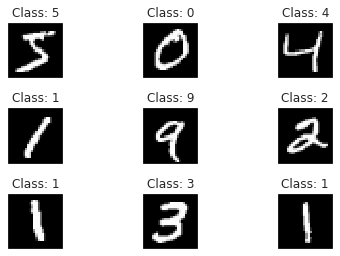

In [19]:
# load the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1) # 9 subplots in 3 rows
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none') # Select color map and plot the digits
  plt.title(f'Class: {y_train[i]}')  # Add the lable of the i-th digit as title of subplot
  plt.xticks([])
  plt.yticks([]) # Remove ticks to look just a bit cooler

As we increase our tolerance, $\epsilon$, for the distance loss after the projection, the minimum dimension required by the Johnson-Lindenstrauss lemma decreases. If we allow $\epsilon$ to be 0.5, the number of dimensions required drops to 352 which is less than half of the original dimensions. However, given such high tolerance, can the model still learn and achieve high accuracy?

In [20]:
# Format training set
X_train = X_train.reshape(60000, 784)
X_train = X_train.astype('float32')
X_train = X_train/255

# Format test set
X_test = X_test.reshape(10000, 784)
X_test = X_test.astype('float32')
X_test = X_test/255

# Encode label using Keras utilities
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("The minimum dimensions with 0.3 tolerance:", min_dim(n=60000, eps=0.3))
print("The minimum dimensions with 0.4 tolerance:", min_dim(n=60000, eps=0.4))
print("The minimum dimensions with 0.5 tolerance:", min_dim(n=60000, eps=0.5))

X_train shape: (60000, 784)
Y_train shape: (60000, 10)
X_test shape: (10000, 784)
Y_test shape: (10000, 10)
The minimum dimensions with 0.3 tolerance: 977
The minimum dimensions with 0.4 tolerance: 550
The minimum dimensions with 0.5 tolerance: 352


We first estabilish a baseline for the original dimension. The model we are using here is a sequential neural network tuned for MNIST dataset.

In [21]:
# Function we shall use to build the benchmark model and later models that will fit to the random projections.
def build_model(k):
    # Build a Sequential model
    model = Sequential()
    # Add Input layer
    model.add(Input(shape=(k,)))
    # First hidden layer
    model.add(Dense(500, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    # Second hidden layer
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.2))
    # Output layer
    model.add(Dense(10, activation='softmax'))
    return model

model_baseline = build_model(784)
# Compile the baseline model
model_baseline.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# Train the model
model_baseline.fit(X_train, Y_train, batch_size=512, epochs=8, verbose=0)
# Evaluate the model
score_baseline = model_baseline.evaluate(X_test, Y_test, verbose=0)
print("Baseline test accuracy:", score_baseline[1])

Baseline test accuracy: 0.9817000031471252


We then loop over differnt dimension number, $k$, to see how randon projection performs on different dimensions.

In [22]:
ks = np.linspace(10, 300, 10).astype(np.int64)
accs = np.array([])
for k in ks:
    sp = SparseRandomProjection(n_components = k)
    X_train_sp = sp.fit_transform(X_train)
    X_test_sp = sp.transform(X_test)
    clear_session()
    model = build_model(k)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    model.fit(X_train_sp, Y_train, batch_size=512, epochs=8, verbose=0)
    score = model.evaluate(X_test_sp, Y_test, verbose=0)
    accs = np.append(accs, score[1])

We can see that the accuracy score quickly approches to the baseline as the number of dimensions increases. A satisfying result can be achieved after the number of dimensions reaches around 150, which is much lower than the original dimension.This proves the usefulness of random projections in a high dimensionality problem. We can also notice that after around 250 dimensions there is a period of saturation in accuracy gains

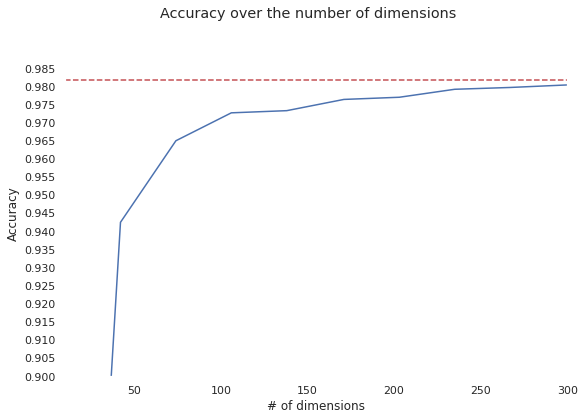

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 6)
fig.suptitle("Accuracy over the number of dimensions")
ax.set_xlabel("# of dimensions")
ax.set_facecolor('w')
ax.grid(False)
ax.set_ylabel("Accuracy")
ax.set_xlim([10, 300])
ax.set_ylim([0.93, 0.99])
ax.set_yticks(np.arange(0.90,0.99, 0.005))
ax.plot(ks, accs)
ax.axhline(score_baseline[1], 0, 300, color = 'r', linestyle = 'dashed');

## Newsgroup Dataset

We pick the newsgroup dataset as our second dataset. Each sample has a very large number of dimensions, 130107, with a 20-class target. There are 11314 samples in total. We decided to pick this dataset since it is very suitable for testing the usefullness of random projections, because of the extremly high number of dimensions the potential gains from dimensionality reductions would be substantial.

In [28]:
X, y = fetch_20newsgroups_vectorized(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("Y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", y_test.shape)
print("The minimum dimensions with 0.1 tolerance:", min_dim(n=9051, eps=0.1))
print("The minimum dimensions with 0.2 tolerance:", min_dim(n=9051, eps=0.2))
print("The minimum dimensions with 0.3 tolerance:", min_dim(n=9051, eps=0.3))

X_train shape: (9051, 130107)
Y_train shape: (9051,)
X_test shape: (2263, 130107)
Y_test shape: (2263,)
The minimum dimensions with 0.1 tolerance: 7288
The minimum dimensions with 0.2 tolerance: 1822
The minimum dimensions with 0.3 tolerance: 809


In contrast with the previous model that had very high accuracy from the start, due to its higher complexity and classification powers, we decided to go for a more humble model for the second application in order to see whether it will be able to achieve a good result on a dataset treated with random projections.

In [29]:
model = LinearSVC()
model.fit(X_train, y_train)
acc_baseline = accuracy_score(y_test, model.predict(X_test))
print("Baseline test accuracy:", acc_baseline)

Baseline test accuracy: 0.897923110914715


In [30]:
ks = np.linspace(100, 5000, 10).astype(np.int64)
accs = np.array([])
for k in ks:
    sp = SparseRandomProjection(n_components = k)
    X_train_sp = sp.fit_transform(X_train)
    X_test_sp = sp.transform(X_test)
    model.fit(X_train_sp, y_train)
    acc = accuracy_score(y_test, model.predict(X_test_sp))
    accs = np.append(accs, acc)

We can observe the similiarly impressive result as MNIST dataset. The accuracy quickly reaches to the baseline, even though the number dimensions are much lower than the original dataset.

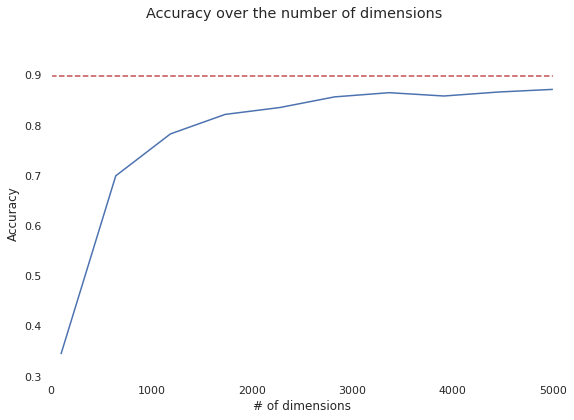

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 6)
fig.suptitle("Accuracy over the number of dimensions")
ax.set_facecolor('w')
ax.grid(False)
ax.set_xlabel("# of dimensions")
ax.set_ylabel("Accuracy")
ax.set_xlim([0, 5000])
ax.set_ylim([0.3, 0.95])
ax.plot(ks, accs)
ax.axhline(acc_baseline, 0, 5000, color = 'r', linestyle = 'dashed');

We have seen through both examples presented that models working on random projections definitely can achieve strong results with substantial dimensionality reduction. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c81f6148-4176-473f-8f5a-411c7abd65e1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>